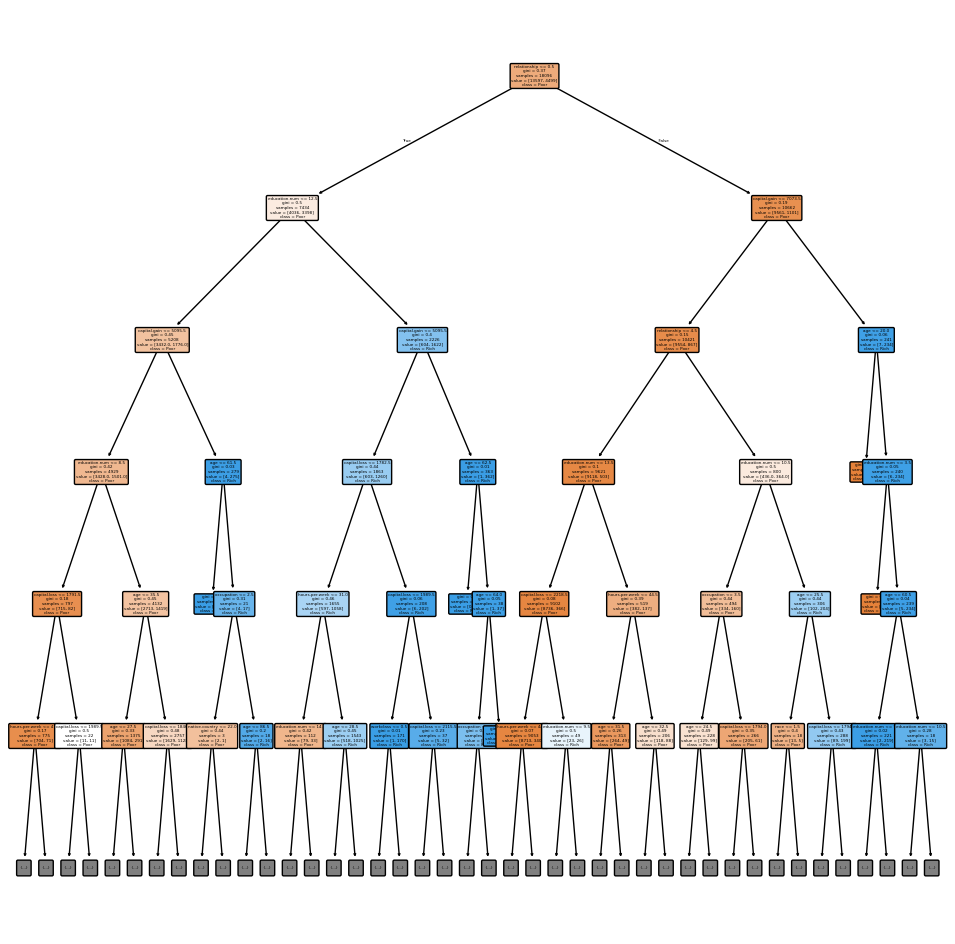

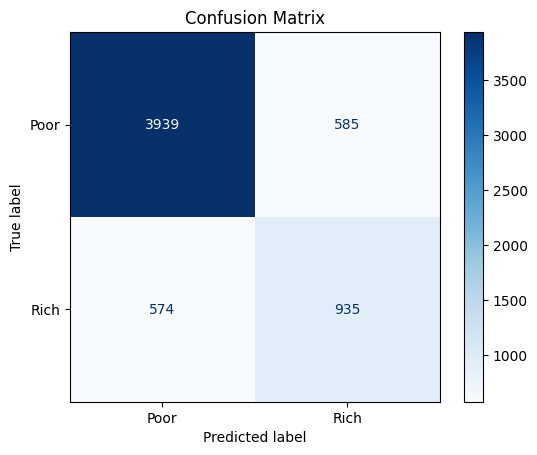

Classification Report:
              precision    recall  f1-score   support

        Poor       0.87      0.87      0.87      4524
        Rich       0.62      0.62      0.62      1509

    accuracy                           0.81      6033
   macro avg       0.74      0.75      0.74      6033
weighted avg       0.81      0.81      0.81      6033

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 1 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30162 non-null  int64
 1   workclass       30162 non-null  int64
 2   education.num   30162 non-null  int64
 3   marital.status  30162 non-null  int64
 4   occupation      30162 non-null  int64
 5   relationship    30162 non-null  int64
 6   race            30162 non-null  int64
 7   sex             30162 non-null  int64
 8   capital.gain    30162 non-null  int64
 9   capital.loss    30162 non-null  int64
 10  hours.per.week  30162 non

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint



# Load dataset
df = pd.read_csv('./Datasets/adult.csv', comment = '#')

# First, create a copy of the dataframe to avoid modifying the original
df_encoded = df.copy()
df_encoded.drop(['fnlwgt', 'education'], axis=1, inplace=True)

# drop all rows that contain '?'
for column in df_encoded.columns:
    df_encoded = df_encoded[df_encoded[column] != '?']

# Apply label encoding to categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['workclass', 'marital.status', 'occupation', 
                      'relationship', 'race', 'sex', 'native.country', 'income']

for column in categorical_columns:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

# Now properly separate features and target
X = df_encoded.drop(columns=['income'])
y = df_encoded['income']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# Build pipeline
model = Pipeline([
    ('full_dt_classifier', DecisionTreeClassifier(random_state=42))  # Train Decision Tree Regressor
])

# Train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# Visualize the decision tree
plt.figure(figsize=(12, 12))
plot_tree(
    model.named_steps['full_dt_classifier'],
    feature_names=X.columns,
    class_names=["Poor", "Rich"],
    filled=True,
    rounded=True,
    max_depth=5,       # Keep tree shallow for readability
    fontsize=3,
    precision=2        # Limit decimals
)

plt.savefig('decision_tree.pdf', format='pdf', dpi=300)
plt.show()

#mse = mean_squared_error(y_val, y_pred)
#print(f'Mean Squared Error: {mse}')

CM = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=["Poor", "Rich"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()  

print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Poor", "Rich"]))

df_encoded.info()

### Hyperparameter tuning

In [26]:
# Hyperparameters search space
param_dist = {
    'full_dt_classifier__max_depth': randint(3, 20),
    'full_dt_classifier__min_samples_split': randint(2, 20),
    'full_dt_classifier__min_samples_leaf': randint(1, 15),
}

# Ranodmized search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter = 300,
    cv = 10,
    scoring = 'r2',
    n_jobs = -1,
    random_state = 42
)

#K_fold = KFold(n_splits=10, shuffle=True, random_state=42)
#cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)

# Fit search
random_search.fit(X_train, y_train)
random_search.fit(X_train, y_train)

# Best model training
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, y_pred_best, target_names=["Poor", "Rich"]))

best_max_depth = best_model.named_steps['full_dt_classifier'].max_depth
best_min_samples_split = best_model.named_steps['full_dt_classifier'].min_samples_split
best_min_samples_leaf = best_model.named_steps['full_dt_classifier'].min_samples_leaf

print(f'Best max_depth: {best_max_depth}')
print(f'Best min_samples_split: {best_min_samples_split}')


Classification Report:
              precision    recall  f1-score   support

        Poor       0.88      0.93      0.90      4524
        Rich       0.75      0.62      0.68      1509

    accuracy                           0.85      6033
   macro avg       0.81      0.78      0.79      6033
weighted avg       0.85      0.85      0.85      6033

Best max_depth: 12
Best min_samples_split: 18


### Classifier comparison
(This is taken from the ensemble lab)

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from xgboost import XGBClassifier        # Requires installation of the package ; Not a native function in sklearn
from lightgbm import LGBMClassifier      # Requires installation of the package; Not a native function in sklearn
from catboost import CatBoostClassifier  # Requires installation of the package; Not a native function in sklearn

class ClassifierComparisonOpt:
    def __init__(self, X, y, test_size=0.3, use_bootstrap=True, random_state=42, cv_folds=10):
        # Split data stratified by labels
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state)

        # Scale features
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(X_train)
        self.X_test  = scaler.transform(X_test)

        self.y_train       = y_train
        self.y_test        = y_test
        self.use_bootstrap = use_bootstrap
        self.cv_folds      = cv_folds
        self.models        = {}
        self.results       = {}
        self.results_df    = None

    # Define the classifiers and their hyperparameters
    def get_models_with_params(self):
        return {
            'Decision Tree': (DecisionTreeClassifier(random_state=42), {
                'max_depth': [None, 10, 11, 12, 13, 14, 15, 16],
                'min_samples_split': [3, 4, 5, 6, 7, 8, 9]
            }),
            'Random Forest': (RandomForestClassifier(bootstrap=self.use_bootstrap, random_state=42), {
                'n_estimators': [50, 100, 200], # I currently don't know how to tune this
                'max_depth': [None, 10, 11, 12, 13, 14, 15, 16],
                'min_samples_split': [3, 4, 5, 6, 7, 8, 9]
            }),
            #'Bagging': (BaggingClassifier(bootstrap=self.use_bootstrap, random_state=42), {
            #    'n_estimators': [50, 100, 200],
            #    'max_samples': [0.5, 1.0],
            #    'oob_score': [True, False],
            #}),
            # SAMME: Stagewise Additive Modeling using a Multi-class Exponential loss
            #'AdaBoost': (AdaBoostClassifier(algorithm='SAMME', random_state=42), {
            #    'n_estimators': [50, 100, 200],
            #    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0]
            #}),
            #'Gradient Boosting': (GradientBoostingClassifier(random_state=42), {
            #    'n_estimators': [50, 100, 200],
            #    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
            #    'max_depth': [3, 5, 10]
            #}),
            #'XGBoost': (XGBClassifier(eval_metric='mlogloss', random_state=42), {
            #    'n_estimators': [50, 100, 200],
            #    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
            #    'max_depth': [3, 5, 10]
            #}),
            #'LightGBM': (LGBMClassifier(random_state=42), {
            #    'n_estimators': [50, 100, 200],
            #    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
            #    'max_depth': [-1, 5, 10]
            #}),
            #'CatBoost': (CatBoostClassifier(verbose=0, random_state=42), {
            #    'iterations': [50, 100, 200],
            #    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
            #    'depth': [4, 6, 10]
            #})
        }

    def fit_models(self):
        results_list = []
        cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
        models_with_params = self.get_models_with_params()

        for name, (model, param_grid) in models_with_params.items():
            print(f"Tuning {name} ...")
            
            grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
            
            start_train = time.time()
            grid_search.fit(self.X_train, self.y_train)
            end_train = time.time()

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(self.X_test)
            end_pred = time.time()

            self.models[name] = {
                'model': best_model,
                'confusion_matrix': confusion_matrix(self.y_test, y_pred)
            }

            metrics = {
                'Model': name,
                'Accuracy': accuracy_score(self.y_test, y_pred),
                'Precision': precision_score(self.y_test, y_pred, average='weighted', zero_division=0),
                'Recall': recall_score(self.y_test, y_pred, average='weighted'),
                'F1 Score': f1_score(self.y_test, y_pred, average='weighted'),
                'Best Params': grid_search.best_params_,
                'Training Time (s)': (end_train - start_train),
                'Prediction Time (s)': (end_pred - end_train),
                'Total Time (s)': (end_pred - start_train)
            }

            results_list.append(metrics)

        self.results_df = pd.DataFrame(results_list)

    def print_summary(self):
        print("\n------ Results Sorted by Accuracy ------")
        print(self.results_df.sort_values(by='Accuracy', ascending=False).to_string(index=False))

        print("\n------ Results Sorted by Total Time ------")
        print(self.results_df.sort_values(by='Total Time (s)', ascending=True).to_string(index=False))

    # Show feature importance for models that support it          
    def show_feature_importance(self):
        importance = {}

        for name, result in self.models.items():
            model = result['model']
            if hasattr(model, 'feature_importances_'):
                importance[name] = model.feature_importances_
            elif hasattr(model, 'coef_'):
                coef = model.coef_
                if coef.ndim == 1:
                    importance[name] = np.abs(coef)
                else:
                    importance[name] = np.mean(np.abs(coef), axis=0)
            else:
                print(f"Feature importance not available for model {name}")

        for name, imp in importance.items():
            sorted_idx = np.argsort(imp)[::-1]
            plt.figure()
            plt.bar(range(len(imp)), imp[sorted_idx], align='center')
            plt.xticks(range(len(imp)), sorted_idx)
            plt.title(f"Feature importance for {name}")
            plt.xlabel("Feature index")
            plt.ylabel("Importance score")
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()


Tuning Decision Tree ...
Tuning Random Forest ...

------ Results Sorted by Accuracy ------
        Model  Accuracy  Precision   Recall  F1 Score                                                    Best Params  Training Time (s)  Prediction Time (s)  Total Time (s)
Random Forest  0.857617   0.852147 0.857617  0.852588 {'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 200}         303.932920             0.216372      304.149293
Decision Tree  0.846381   0.840787 0.846381  0.842219                      {'max_depth': 10, 'min_samples_split': 9}           3.946769             0.001706        3.948475

------ Results Sorted by Total Time ------
        Model  Accuracy  Precision   Recall  F1 Score                                                    Best Params  Training Time (s)  Prediction Time (s)  Total Time (s)
Decision Tree  0.846381   0.840787 0.846381  0.842219                      {'max_depth': 10, 'min_samples_split': 9}           3.946769             0.001706        3.948475

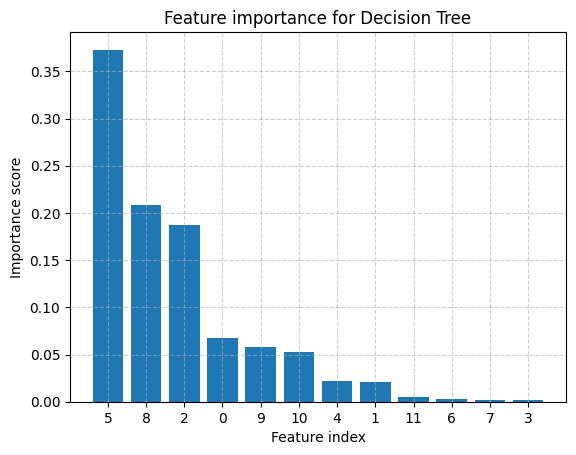

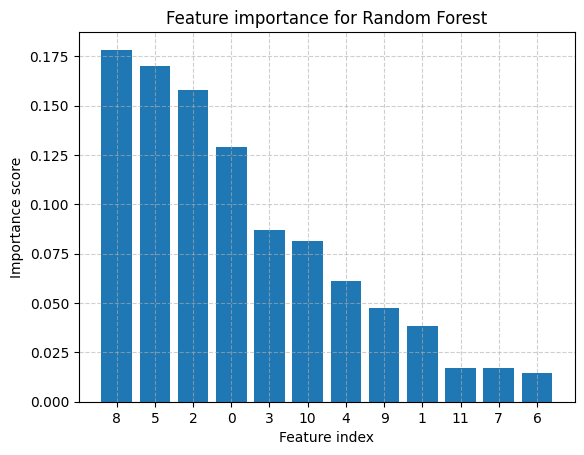

In [12]:
# ===== MAIN =====
# optimized classifiers and find their hyperparameters
clf_opt = ClassifierComparisonOpt(X_train, y_train)
clf_opt.fit_models()
clf_opt.print_summary()

# Show feature importance for each model
clf_opt.show_feature_importance()